# Tesina: Riconoscimento di cifre scritte a mano
## Maddalena Ghiotti, s332834, Apprendimento Statistico
Partendo da un dataset di cifre scritte a mano, andrò ad implementare un Random forest a partire da comandi di base, per poi effettuare un confronto di performance con l'algoritmo già implementato e presente nel pacchetto python _sklearn_ e con la _support vector machine_ e i _multi-layer perceptron_, da me implementati durante il corso triennale Matematica per l'Intelligenza Artificiale. Potrò quindi trarre delle conclusioni sul modello più adatto da utilizzare per l'obiettivo preposto.

Le sezioni _Dataset_, _Importazione Moduli e Pacchetti_, _Caricamento e Preparazione Dataset_, _Elaborazione iniziale e visualizzazioni_ e _Suddivisione del Dataset in Training, Validation e Test Set_ sono riportate quasi invariate dalla tesina di Matematica per l'Intelligenza Artificiale.

## Dataset
Il dataset su cui andremo a lavorare raccoglie 250 campioni di cifre scritte a mano da ognuno dei 44 individui coinvolti nell’esperimento. Ciascuno ha dovuto scrivere su una tavoletta sensibile alla pressione WACOM PL-100V con display LCD integrato, in appositi riquadri di risoluzione 500 per 500 pixel. La tavoletta inviava ad un PC Intel 486 tramite cavo a intervalli di tempo fissi (frequenza di campionamento) di 100 millisecondi, le coordinate $x$ e $y$ e i valori di livello di pressione della penna. Ai partecipanti è stata data la possibilità di correggere eventuali errori o modificare quanto scritto se non soddisfatti, anche se le prime 10 cifre scritte da ciascuno sono ignorate a priori e hanno lo scopo di far prendere agli scrittori familiarità con lo strumento.

Il dataset a disposizione tiene conto solamente delle coordinate ($x, y$) e non della pressione, e i valori delle coordinate sono stati normalizzati (resi così invarianti per traslazione o scalamento), in modo che entrambi varino tra 0 e 100 con almeno uno 0 e almeno un 100 (_min-max scaler_).

Le cifre campionate sono rappresentate come una sequenza di T punti ($x_i$, $y_i$) regolarmente spaziati, a differenza della sequenza di input, che è regolarmente distribuita nel tempo. Quindi, la dimensione del vettore di input è 2*T e nel nostro caso specifico T=8.

## Importazione Moduli e Pacchetti
Qui di seguito è riportato il tratto di codice finalizzato all'importazioje di tutti i pacchetti necessari per lo svolgimento succesivo.

In [6]:
# STILE DI VISUALIZZAZIONE PLOT FATTI CON MATPLOTLIB
%matplotlib inline
#
#
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer, accuracy_score

#from sklearn_evaluation import plot  #Per heatmap
import seaborn as sn  #Per heatmap


## Caricamento e Preparazione Dataset

Provvediamo al caricamento del dataset, precedentemente scaricato in locale. Il dataset è già stato suddiviso in un training e in un test set, che di seguito chiameremo _suggestedTrainingData_ e _suggestedTestData_. Il primo contiene i campioni effettuati su 30 dei 44 scrittori, mentre il secondo contine i campioni dei restanti 14.
Noi andremo a trattare solamente il _suggestedTrainingData_, che divideremo a sua volta in training e test per effettuare test _su scrittori noti_. Il _suggestedTestData_ verrà successivamente utilizzato per un ulteriore test finale _su scrittori ignoti_.

D'ora in poi denoteremo il _suggestedTrainingData_ con $\mathcal{D}$ e lo considereremo come un insieme di $m\in\mathbb{N}$ coppie formate dal vettore colonna in $\mathbb{R}^n$ del campione e il relativo target

$$\mathcal{D} = \{(\boldsymbol{x}_1, \boldsymbol{y}_1),\ldots ,(\boldsymbol{x}_m, \boldsymbol{y}_m)\}, \quad \quad \boldsymbol{x}_i\in \mathbb{R}^n$$

e utilizzeremo la matrice dei campioni $X$, in cui troviamo gli $m$ campioni sulle righe e le $n$ feature sulle colonne. La classe di output di ogni campione è salvata nel vettore $Y$ a parte, dove $y_i$ identifica la classe del campione $x_i$ tra le $p$ possibili. 

$$X = \begin{bmatrix} \boldsymbol{x}_1^\top\\ \vdots\\ \boldsymbol{x}_m^\top \end{bmatrix} \quad Y = \begin{bmatrix} y_1\\ \vdots\\ y_m \end{bmatrix}$$

Nel caso specifico, come vedremo, $m=7494$, $n=16$ e $p=10$.

Ecco riportato qui sotto il _suggestedTrainingData_.

In [7]:
# IMPORT DATA
suggestedTrainingData = pd.read_csv('pendigits.tra', names=["x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "x5", "y5", "x6", "y6", "x7", "y7", "x8", "y8", "class"])
suggestedTestData = pd.read_csv('pendigits.tes', names=["x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "x5", "y5", "x6", "y6", "x7", "y7", "x8", "y8", "class"])

dataset = suggestedTrainingData.copy()
display(dataset)

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,0,82,9,59,56,34,41,0,10,30,3,67,42,96,100,100,5
7490,49,100,0,70,24,56,100,65,86,85,44,77,21,38,6,0,4
7491,100,98,60,100,24,87,3,58,35,51,58,26,36,0,0,5,5
7492,59,65,91,100,84,96,72,50,51,8,0,0,45,1,100,0,1


In [8]:
print('TRAINING SET SUGGERITO')
suggestedTrainingData.info()
print('\nTEST SET SUGGERITO')
suggestedTestData.info()
print()

TRAINING SET SUGGERITO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7494 entries, 0 to 7493
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x1      7494 non-null   int64
 1   y1      7494 non-null   int64
 2   x2      7494 non-null   int64
 3   y2      7494 non-null   int64
 4   x3      7494 non-null   int64
 5   y3      7494 non-null   int64
 6   x4      7494 non-null   int64
 7   y4      7494 non-null   int64
 8   x5      7494 non-null   int64
 9   y5      7494 non-null   int64
 10  x6      7494 non-null   int64
 11  y6      7494 non-null   int64
 12  x7      7494 non-null   int64
 13  y7      7494 non-null   int64
 14  x8      7494 non-null   int64
 15  y8      7494 non-null   int64
 16  class   7494 non-null   int64
dtypes: int64(17)
memory usage: 995.4 KB

TEST SET SUGGERITO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
--

Come possiamo osservare dalle informazioni sul dataset, non ci sono elementi mancanti. L'assenza di elementi null è confermata dalla descrizione del dataset presnte sul sito di origine, citato nelle fonti. Possiamo inoltre confermare che i dati sono di tipo intero e sono divisi nei due sottoinsiemi secondo un rapporto
$$\%suggestedTrainingData = \frac{|suggestedTrainingData|}{|suggestedTrainingData+suggestedTestData|}*100 = \frac{7494}{7494+3498}*100 = 68\%$$

$$\%suggestedTestData = \frac{|suggestedTestData|}{|suggestedTrainingData+suggestedTestData|}*100 = \frac{3498}{7494+3498}*100 = 32\%$$

## Elaborazione iniziale e visualizzazioni

Mostriamo innanzitutto la distribuzione dei campioni tra le classi. Possiamo notare come le classi siano equilibrate, nonostante non siano perfettamente eque. Da una presenza di 780 campioni circa per le classi _0, 1, 2, 4, 7_, si passa a circa 720 per le classi _3, 5, 6, 8, 9_

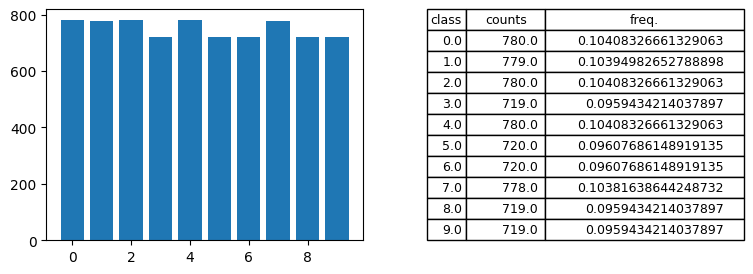

In [4]:
M, N = dataset.shape

class_cont_freq = pd.concat([dataset['class'].value_counts(), dataset['class'].value_counts()/M], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  # alterantiva al metodo 'rename' cambiare il nome a tutte le colonne (comodo quando ce ne sono più di una con stesso nome)
class_cont_freq.index.name = 'class'

class_cont_freq = class_cont_freq.sort_index() #.transpose())
class_cont_freq=class_cont_freq.reset_index()

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(121)
ax1.bar([i for i in np.arange(0, 10)], dataset['class'].value_counts().sort_index())
ax2 = fig.add_subplot(122)
font_size = 16
bbox = [0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText= class_cont_freq.values, bbox=bbox, colLabels= class_cont_freq.columns, colWidths=[0.2,0.4,1])
#plt.savefig('Class_distribution',dpi=300)
plt.show()

Inoltre è possibile ricostruire le cifre originali a partire dalle coppie di punti. Qui di seguito sono rappresentate tutte, partendo dalle coordinate medie, calcolate su tutto il _suggestedTrainingData_ suddiviso in classi. E' evidenziato il primo punto.

E' interessante notare come in numero 5 sia difficilmente riconoscibile. Ciò è probabilmente dovuto dal diverso ordine dei tratti che ogni scrittore segue; infatti, il punto finale è il risultato della media dell'ultimo punto di chi traccia prima la linea orizzontale e di chi prima la pancia. L'abbondante spazio bianco circostante il numero, caratteristico anche della cifra 8, è anche un segno della varietà di modi in cui questo numero è tracciabile.

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\2415859654.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(means[0],means[1])


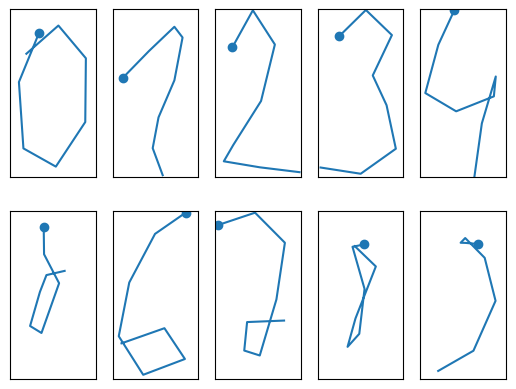

In [5]:
fig = plt.figure()
for i in range(10):
    means = dataset[dataset['class']==i].mean(axis=0)
    plt.subplot(2,5,i+1)
    plt.plot(means[0:16:2],means[1:16:2])
    plt.scatter(means[0],means[1])
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
    plt.xlim([0,100])
    plt.ylim([0,100])
#plt.savefig('Numbers',dpi=300)
plt.show()

Dalla tabella e dai grafici qui sotto riportati possiamo vedere come i numeri vengano generalmente tracciati partendo dall'alto e muovendosi verso il basso. Dato che la maggior parte gli scrittori traccia le cifre partendo dal margine superiore, la deviazione standard legata alla prima coordinata y è molto bassa, a differenza dalla prima coordiata x e dal'ultimo punto che sono molto dipendenti dalla cifra in questione.

Possiamo anche osservare come _min_ e _max_ di ciascuna coordinata siano sempre _0_ e _100_. Questo significa che ciascun punto della sequenza è stato il punto più in alto di tutti, per almeno uno scrittore, così come il più basso, il più a destra e il più a sinistra.

In [6]:
desc = dataset.iloc[:,:-1].describe()
display(desc)

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8
count,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000,7494.000000
mean,37.384307,84.679343,40.005604,82.889512,50.878303,65.044436,51.471844,44.599680,57.129971,34.069122,61.417401,35.782092,54.699760,35.800774,46.813718,28.565386
std,33.322024,16.848420,26.256025,19.638582,34.927201,27.377341,30.680075,30.659478,33.680340,27.459989,37.130762,27.495836,22.599781,33.223611,41.531794,35.811094
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,76.000000,20.000000,70.000000,17.000000,48.000000,28.000000,22.000000,30.000000,7.000000,25.000000,12.000000,41.000000,7.000000,0.000000,0.000000
50%,31.000000,89.000000,39.000000,89.000000,56.000000,71.000000,54.000000,42.000000,60.000000,33.000000,74.000000,32.000000,53.000000,28.000000,39.000000,8.000000
75%,61.000000,100.000000,58.000000,100.000000,81.000000,86.000000,75.000000,65.000000,88.000000,55.000000,98.000000,57.000000,69.000000,48.000000,100.000000,51.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


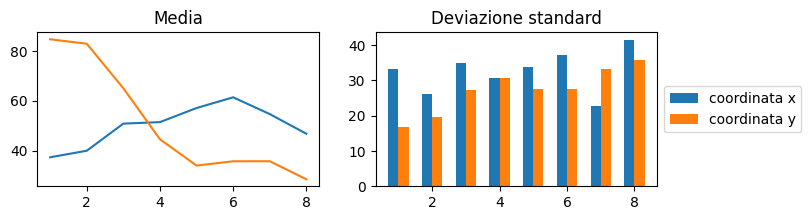

In [7]:
plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title('Media')
plt.plot(np.arange(1, 9), desc.iloc[1,0:16:2], label= 'coordinata x')
plt.plot(np.arange(1, 9), desc.iloc[1,1:16:2], label = 'coordinata y')
plt.subplot(1,2,2)
plt.title('Deviazione standard')
plt.bar(np.arange(1, 9)-0.15, desc.iloc[2,0:16:2], width=0.3,label= 'coordinata x')
plt.bar(np.arange(1, 9)+0.15, desc.iloc[2,1:16:2], width=0.3,label = 'coordinata y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('Media_Varianza',dpi=300)
plt.show()

Dato che abbiamo visto che la maggior parte dei numeri vengono tracciati dall'alto, ma che anche il primo punto può essere sul margine inferiore, ci chiediamo qual numeri siano causa di questa "incongruenza". Di seguito un approfondimento sulle sole cifre del _suggestedTrainingData_ che hanno il primo punto più in basso di tutti gli altri. Come possiamo osservare le uniche cifre che vengono tracciate partendo dal basso sono il 9 e l'1. A destra vengono tracciati i due numeri prendendo i punti medi dei soli campioni che hanno il punto di partenza sul margine inferiore.

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\2661397172.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a1.scatter(means9[0],means9[1])
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\2661397172.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a2.scatter(means1[0],means1[1])


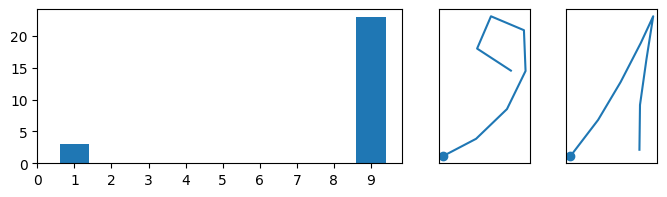

In [8]:
y1zero = dataset[dataset['y1']==0]

means9 = y1zero[y1zero['class']==9].mean(axis=0)
means1 = y1zero[y1zero['class']==1].mean(axis=0)

f, (a0, a1, a2) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [4, 1, 1]}, figsize=(8,2))
a0.bar(y1zero['class'].unique(),y1zero['class'].value_counts())
a0.set_xticks(range(10))
a1.plot(means9[0:16:2],means9[1:16:2])
a1.scatter(means9[0],means9[1])
a1.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
a2.plot(means1[0:16:2],means1[1:16:2])
a2.scatter(means1[0],means1[1])
a2.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
#plt.savefig('Numbers_fromBottom',dpi=300)
plt.show()


## Suddivisione del Dataset in Training, Validation e Test Set

Suddividiamo il _suggestedTrainingData_ ($\mathcal{D}$) in _Training set_, _Validation set_ e _Test set_.

Il training set è definito come $\mathcal{T} = \{(\boldsymbol{x}_1, y_1), \ldots , (\boldsymbol{x}_T, y_T) \}$, cioè come le coppie campione-classe formate da $T$ righe casuali di $X$ e dalle corrispondenti $T$ di $Y$. Indichiamo rispettivamente l'insieme dei vettori e l'insieme delle classi in $\mathcal{T}$ con 

$$X_{\mathcal{T}}=\{\boldsymbol{x}_1,\ldots ,\boldsymbol{x}_T\} \quad \text{e} \quad Y_{\mathcal{T}}=\{y_1,\ldots ,y_T\}\,.$$

I restanti campioni sono divisi analogamente tra il _Validation set_, che denotiamo con $\mathcal{V}$, e il _Test set_ ($\mathcal{P}$). 


La suddivisione che vediamo di seguito verrà utilizzata per l'addestramento e il test _su scrittori noti_.

1. $|\mathcal{T}| = 70\% |\mathcal{D}|$
1. $|\mathcal{V}| = 10\% |\mathcal{D}|$
1. $|\mathcal{P}| = 20\% |\mathcal{D}|$

In [9]:
# X_train, X_test: matrici delle features di training e test set, rispettivamente, ottenute da X
# y_train, y_test: vettori delle classi di training e test set, rispettivamente, ottenuti da y
random_seed = 42
test_p = 0.20
val_p = 0.125 #Il valore è rispetto al training+validation (0.8*0.125)=0.1

X_trainval, X_test, y_trainval, y_test = train_test_split(dataset.iloc[:,:-1], dataset.iloc[:,-1], test_size=test_p, random_state=random_seed, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_p, random_state=random_seed, shuffle=True)

display(pd.DataFrame({'Training': X_train.shape, 'Validation': X_val.shape, 'Test': X_test.shape}, index=['N. sanmples', 'N.features']))

,Training,Validation,Test
N. sanmples,5245,750,1499
N.features,16,16,16


# Random Forest

Per comprendere il funzionamento del Random Forest è necessario prima concentrarsi sul significato di albero decisionale.

## Alberi decisionali

Lo spazio dei possibili valori delle feature è denominato _spazio dei predittori_ ($\mathcal{Z}$) ed è associato al nodo radice del nostro albero decisionale. Il nodo radice è inoltre associato ad una _splitting rule_, cioè ad una funzione $s:\mathcal{Z} \to \{False, True\}$ o $s:\mathcal{Z} \to \{0, 1\}$ che abbina ad ogni combinazione di valori delle feature un etichetta Vero o Falso, sulla base della soddisfacibilità di un dato criterio da parte della combinazione. 
Lo spazio $\mathcal{Z}$ viene quindi diviso in due regioni disgiunte $\mathcal{R}_T$ e $\mathcal{R}_F$, comprendenti le combinazioni che restituiscono le etichette Vero e Falso rispettivamente se sottoposte alla splitting rule. Le regioni sono tali che $\mathcal{R}_T\cup\mathcal{R}_F=\mathcal{Z}$. Si generano ora due nodi figli, ciascuno abbinato ad una delle due regioni create. Insieme allo spazio dei predittori, anche il training set $\mathcal{T}$ viene suddiviso tra i due nodi figli sulla base della splitting rule, e si creano anche in questo caso i sotto-insiemi 

$$
\sigma_T:=\{(\boldsymbol{x}, y) : s(\boldsymbol{x})=True\} \subseteq \mathcal{T} \quad \text{e} \quad \sigma_F:=\{(\boldsymbol{x}, y) : s(\boldsymbol{x})=False\} \subseteq \mathcal{T}
$$

Il procedimento si ripete per ogni nuovo nodo $v$ dell'albero, corrispondente alla regione $\mathcal{R}_{v}$: il nodo viene associato ad una splitting rule $s_v$, sulla base della quale la regione $\mathcal{R}_{v}$ viene divisa nelle sotto-regioni $\mathcal{R}_{v_T}$ e $\mathcal{R}_{v_F}$ abbinate ai nuovi nodi figli $v_T$ e $v_F$ e il sotto-insieme del training set $\sigma$ abbinato al nodo $v$ viene suddiviso negli ulteriori sotto-insiemi $\sigma_{T}$ e $\sigma_{F}$.

Non appena un criterio di arresto viene soddisfatto, il processo iterativo termina. A tal punto, ogni nodo foglia $w \in \mathcal{W}$ sarà abbianato ad un sotto-insieme
$$\sigma_w= \{(\boldsymbol{x}_{w_1}, y_{w_1}), \ldots , (\boldsymbol{x}_{w_T}, y_{w_T}) \}\subseteq\mathcal{T}$$
e ad una regione $\mathcal{R}_{w}$ di $\mathcal{Z}$, che a sua volta associamo ad una _funzione di predizione regionale_ $g^w$. Possiamo osservare come tutti i campioni contenuti in $\sigma_w$ facciano parte della regione $\mathcal{R}_w$.

Nel caso di una classificazione tra $p$ classi $j=0,1,...,p-1$, la funzione di predizione della regione $\mathcal{R}_{w}$ è costante e uguale alla moda delle classi delle osservazioni in $\sigma_w$, cioè:

$$g^w(\boldsymbol{x})=\argmax_{j\in\{0,1,...,p-1\}}p_j^w \quad \text{con} \quad p_j^w=\frac{1}{|\sigma_w|}\sum_{(\boldsymbol{x},y)\in\sigma_w}\mathbb{1}_{\{y=j\}}$$

La quantità $p_j^w$ rappresenta la proporzione delle osservazioni in $\sigma_w$ aventi classe $j$.

La funzione di predizione complessiva $g(\boldsymbol{x})$, cioè la funzione che restituisce la classe di appartenenza dato un campione non noto, è data da:

$$g(\boldsymbol{x})=\sum_{w\in\mathcal{W}}g^w(\boldsymbol{x})\mathbb{1}_{\{\boldsymbol{x}\in\mathcal{R}_w\}}$$

dove $\boldsymbol{x}$ rappresenta un qualunque vettore nello spazio dei predittori ($\boldsymbol{x}\in\mathcal{Z}$).

Per il calcolo della _loss_ di una funzione di predizione $g(x)$ nel caso di un albero decisionale si usa la formula:

$$\ell_{\mathcal{T}}(g)=\sum_{w\in\mathcal{W}}\frac{1}{T}\sum_{i=1}^T \mathbb{1}_{\{\boldsymbol{x}_i\in\mathcal{R}_w\}}Loss(y_i,g^w(\boldsymbol{x}_i))$$


### Splitting rule

Dato un nodo dell'albero in esame $v$, se supponiamo che $\mathcal{Z}=\mathbb{R}^n$, possiamo scegliere un predittore $z$ e utilizzare come tipologia di splitting rule la seguente:

$$s(\boldsymbol{x})=\mathbb{1}_{\{x_z\leq \xi\}} \quad \text{con} \quad 1\leq z \leq n \quad \text{e} \quad \xi\in\mathbb{R}$$

I parametri $z$ e $\xi$ sono scelti al fine di minimizzare la loss dopo lo splitting, cioè:

$$ 
\frac{1}{T}\sum_{i=1}^T \mathbb{1}_{\{(\boldsymbol{x},y)\in \sigma_T\}} Loss(y_i,g^T(\boldsymbol{x}_i))+\frac{1}{T}\sum_{i=1}^T \mathbb{1}_{\{(\boldsymbol{x},y)\in \sigma_F\}} Loss(y_i,g^F(\boldsymbol{x}_i))=\frac{1}{T}\sum_{(\boldsymbol{x},y)\in \sigma_T} \mathbb{1}_{\{y\neq g^T(\boldsymbol{x})\}}+\frac{1}{T}\sum_{(\boldsymbol{x},y)\in \sigma_F} \mathbb{1}_{\{y\neq g^F(\boldsymbol{x})\}}
$$

dal momento che si utilizza la funzione di loss per la classificazione $Loss(y,g(\boldsymbol{x}))=\mathbb{1}_{\{y\neq g(\boldsymbol{x})\}}$.


### Criteri di terminazione

I possibili criteri di terminazione sono molteplici. Nel caso esaminato si sono considerati tre diversi criteri, applicati contemporaneamente, cioè l'algoritmo termina non appena si verifica una delle seguenti condizioni:

- La profondità dell'albero raggiunge un valore prefissato 
- Il numero di campioni in un nodo risulta minore o uguale ad un certo valore prefissato
- Il miglioramento della loss raggiungibile per mezzo di una biforcazione non è significativo

### Predizione

Quando si desidera classificare uno o più nuovi campioni, non utiizzati per l'apprendimento, per esempio il test set $\mathcal{P}$, si suppone di far "scorrere" l'insieme di campioni attraveso il nostro albero decisionale a partire dalla radice. Ad ogni campione $\boldsymbol{x}_i$ viene applicata la prima splitting-rule e i campioni vengono spostati nei nodi figli corrispondenti ai risultati ottenuti. Si ripete così per ogni nodo, smistando il test set tra i diversi rami dell'albero, fino a quando ciascun $\boldsymbol{x}_i$ non si trovi in un nodo foglia.

A questo punto ogni campione $\boldsymbol{x}_i$ viene associato alla predizione risultante dalla funzione di predizione $g^w$ del nodo foglia $w$ in cui il campione si trova.

## Applicazione dell'Albero Decisionale

Definiamo qui di seguito le classi _Node_ e _Tree_.

La classe _Node_ racchiude gli oggetti nodo dell'albero. Ogni nodo presenta come attributi:
- Il livello dell'albero in cui si trova
- Il collegamento ai nodi figli
- I parametri della splitting rule associata
- Il valore della funzione di predizione abbianata al nodo, solo nel caso di nodi foglia  

In questo modo l'albero è facilmente visitabile, partendo dalla radice e muovendosi verso le foglie. Il metodo presente nella classe _Node_ consente di associare ad nodo in esame i suoi due nodi figli nel momento di uno splitting.

In [18]:
class Node:
    def __init__(self):
        self.true_child = None
        self.false_child = None
        self.depth = 0
    
    def add_children_splitting(self,true, false,j,xi):
        self.true_child = true
        self.false_child = false
        self.feature = j
        self.xi = xi

La classe _Tree_ racchiude gli oggetti albero. Tra gli attributi della classe troviamo i parametri per i criteri di terminazione e il nodo radice, da cui si può iniziare la visita dell'albero. L'oggetto albero contiene come attributo solo la radice, anche se l'intero albero è di per sè formato da tutti i collegamenti interni tra i nodi a partire dalla radice.  
Quando si crea un oggetto albero, è necessario passare come parametro, oltre ai valori per la terminazione, il training set da usare per l'addestramento. Non è infatti possibile creare un albero senza un insieme di campioni di riferimento. A partire dal training set viene creato il nodo radice e poi tutti gli altri a seguire.  
Il metodo per la costruzione dell'albero, così come quello per la predizione di un nuovo campione per mezzo dell'albero, è di tipo ricorsivo, in quanto non è nota a priori la profondità di ciascun ramo e le bisezioni sarebbero difficilmente gestibili per mezzo di clicli _for_ o cicli _while_.

In [20]:
class Tree:
    def __init__(self,training,stop_leaf,stop_depth,stop_loss):
        self.stop_leaf = stop_leaf
        self.stop_depth = stop_depth
        self.stop_loss = stop_loss
        self.root = Node()
        self.dim = training.shape[0]
        self.create_subtree(training,self.root)

    def create_subtree(self,training,node):      
        n_feature = training.shape[1]-1
        n_samples = training.shape[0]

        if n_samples > self.stop_leaf:
            feature=None
            value=None
            min_loss=np.inf
            for j in range(0,n_feature):
                unique_feature =np.unique(training[:,j])
                if len(unique_feature)>1: 
                    possibile_splitting = unique_feature[0:-1]    
                    for xi in possibile_splitting:
                        mask_true = (training[:,j] <= xi) #@np.ones((1,training.shape[1]))
                        
                        class_training_true = training[mask_true,-1]
                        elementi_unici_true, conteggi_true = np.unique(class_training_true, return_counts=True)

                        class_training_false = training[~mask_true,-1]
                        elementi_unici_false, conteggi_false = np.unique(class_training_false, return_counts=True)

                        obj = (1/self.dim)*(len(class_training_true)-max(conteggi_true))+(1/self.dim)*(len(class_training_false)-max(conteggi_false))
                        if obj<min_loss:
                            min_loss=obj
                            feature=j
                            value=xi

            old_unique, old_count = np.unique(training[:,-1], return_counts=True)
            old_loss = (1/self.dim)*(training.shape[0]-max(old_count))
            diff_loss = old_loss - min_loss

            if  node.depth+1<=self.stop_depth and diff_loss>=self.stop_loss and value != None: 
                mask_true = (training[:,feature] <= value)
                training_true = training[mask_true]
                training_false = training[~mask_true] 

                trueNode = Node()
                falseNode = Node()
                node.add_children_splitting(trueNode,falseNode,feature,value)
                trueNode.depth = node.depth+1
                falseNode.depth = node.depth+1
                self.create_subtree(training_true, trueNode)
                self.create_subtree(training_false, falseNode)
            else:
                unique_elements, count = np.unique(training[:,-1], return_counts=True)
                prediction_function = unique_elements[np.argmax(count)]
                node.prediction_function = prediction_function

        else:
            unique_elements, count = np.unique(training[:,-1], return_counts=True)
            prediction_function = unique_elements[np.argmax(count)]
            node.prediction_function = prediction_function     
 
            
    def predict(self,test):
        test["index"] = np.arange(test.shape[0])
        test_data = test.values
        pred = np.empty(test_data.shape[0])
        self.predict_subtree(test_data,self.root,pred)
        test.drop("index", axis=1, inplace=True)
        return pred.astype(int)
    
    def predict_subtree(self,test,node,predictions):
        if node.true_child == None:
            predictions[test[:,-1]]=node.prediction_function
        else:
            mask_true = (test[:,node.feature] <= node.xi)
            test_true = test[mask_true]
            test_false = test[~mask_true]
            self.predict_subtree(test_true,node.true_child, predictions)
            self.predict_subtree(test_false,node.false_child, predictions)
   
        

### Grid Search

La _grid search_ è una tecnica utilizzata per trovare i valori degli iper-parametri che generano il modello con le migliori prestazioni.

Per ogni iper-parametro $p_h$  con $h=1,...,H$ si seleziona un intervallo discreto di valori $I_h$. Generalmente gli intervalli non contengono quantità equispaziate, ma la selezione segue un criterio stabilito che può essere, per esempio, un campionamento casuale determinato da una distribuzione di probabilità.

Si considerano dunque tutte le combinazioni degli iper-parametri

$$
G= I_1 \times I_2 \times ... \times I_H
$$

e si addestrano e validano tutti i $|G|$ modelli.

Per ciascuno dei tre iper-parametri, definenti i criteri di terminazione, scegliamo dunque un intervallo discreto di valori ed effettuiamo l'addestramento dei $|G|$ alberi decisionali. Ciascun albero verrà poi usato per predirre le classi dei campioni appartenenti al Validation set e verrà selezionato come albero definitivo quello che porterà all'accuratezza migliore sul Validation set.

In [21]:
training = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_val, y_val], axis=1)

In [22]:
GRID = {
    'stop_leaf': [1,2,5,10,15],  #10,10,0.001
    'stop_depth': [5,10,15],
    'stop_loss': [0.01, 0.001, 0.0001]
}

cols={'train_accuracy':[],'validation_accuracy':[],'time':[]}
for k in GRID.keys():
    cols[k]=[]
Results=pd.DataFrame(cols)

for g in ParameterGrid(GRID):  # Iterazione su tutte le combinazioni della Grid Search

    # Misurazione del tempo
    start=time.time()

    #Addestramento dell'albero
    decision_tree = Tree(training.values,**g)
    stop=time.time()

    # Predizione su training e validation set e calcolo delle accuratezze
    pred_train = decision_tree.predict(training)
    accuracy_train = accuracy_score(y_train,pred_train)
    pred_val = decision_tree.predict(test)
    accuracy_val = accuracy_score(y_val,pred_val)

    # Aggiornamento del dataset con i risultati
    rowToAppend=g.copy()
    rowToAppend['train_accuracy']=accuracy_train
    rowToAppend['validation_accuracy']=accuracy_val
    rowToAppend['time']=stop-start
    Results=pd.concat([Results,pd.Series(rowToAppend).to_frame().T],axis=0,ignore_index=True)

In [79]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

Creiamo ora delle heatmap che mostrino i risultati della Grid Search. Rappresentiamo, per ogi combinazione di iper-parametri, i valori dell'accuratezza sul training set, sul validation set e il tempo dell'addestramento.

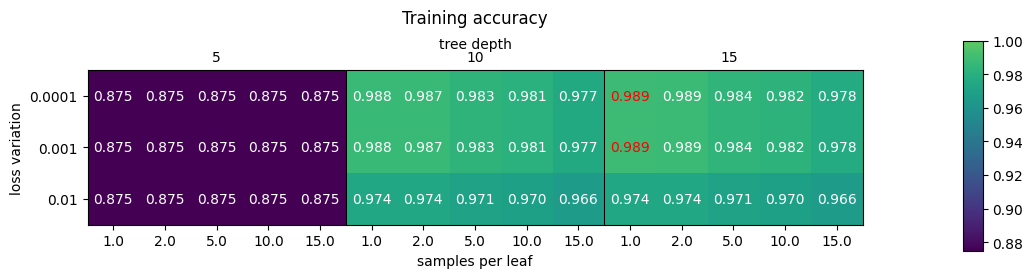

MIGLIORI IPERPARAMETRI


,train_accuracy,validation_accuracy,time,stop_leaf,stop_depth,stop_loss
31,0.988751,0.944,2.629634,1.0,15.0,0.001


In [85]:
scoreInterest= 'train_accuracy'
vmin=Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(10,3))

square=pd.DataFrame()
for sd in GRID['stop_depth']:
    df = Results[Results['stop_depth']==sd]
    df=df.pivot(index='stop_loss', columns='stop_leaf', values=scoreInterest)
    square=pd.concat([square,df], axis=1)

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("loss variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.3f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=4.5,c="black",linewidth=0.75,zorder=0)
ax.axvline(x=9.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(7, -1.5, 'Training accuracy', ha="center", va="center", fontsize=12)
ax.text(7, -1, 'tree depth', ha="center", va="center")
ax.text(2, -0.75, GRID['stop_depth'][0], ha="center", va="center")
ax.text(7, -0.75, GRID['stop_depth'][1], ha="center", va="center")
ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('Tree_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=Results[scoreInterest].astype(float).idxmax()
bestModel = Results.iloc[max_elem_row]
display(pd.DataFrame(bestModel).transpose())

Come ci aspettiamo, l'accuratezza è molto inferiore quando interrompiamo la costruzione dell'albero al raggiungimento del livello 5. Il numero di campioni in ogni foglia è ancora molto elevato, dunque la probabilità che siano tutti appartenenti alla stessa classe è relativamente bassa. Ecco perchè la accuratezza che ne deriva è inferiore. La netta differenza di accuratezza tra la terminazione alla profondità 5 e la terminazione a profondità maggiori, fa dedurre che il citerio sulla profondità dell'albero sia sempre mordente nel primo caso. Ciò è confermato dal valore sempre uguale dell'accuratezza in tale insieme di combinazioni.  
Al contrario, sempre come previsto, l'accuratezza migliore si ha quando la profondità massima è 15. Non essendoci elementi di casualità nella costruzione dell'albero, l'accuratezza sull'insieme di training è maggiore più l'albero si ramifica e va in profondità, meno quindi i criteri di terminazione sono stringenti. La combinazione di iper-parametri meno stringente, come si nota dalla heatmap, è infatti la migliore in termini di accuratezza generata.

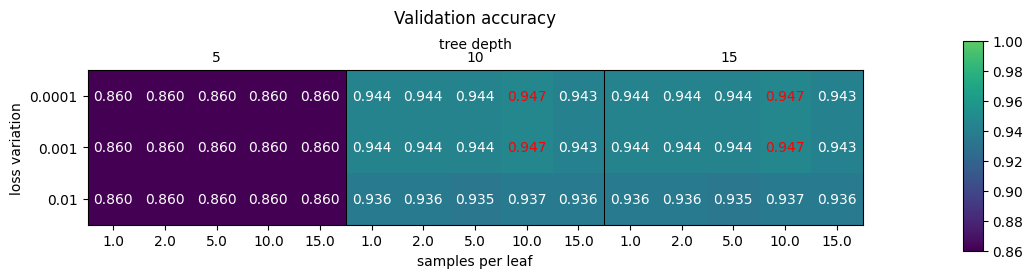

MIGLIORI IPERPARAMETRI


,train_accuracy,validation_accuracy,time,stop_leaf,stop_depth,stop_loss
25,0.981316,0.946667,2.483333,10.0,10.0,0.001


In [87]:
scoreInterest= 'validation_accuracy' #train_accuracy, time
vmin=Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(10,3))

square=pd.DataFrame()
for sd in GRID['stop_depth']:
    df = Results[Results['stop_depth']==sd]
    df=df.pivot(index='stop_loss', columns='stop_leaf', values=scoreInterest)
    square=pd.concat([square,df], axis=1)

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("loss variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.3f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=4.5,c="black",linewidth=0.75,zorder=0)
ax.axvline(x=9.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(7, -1.5, 'Validation accuracy', ha="center", va="center", fontsize=12)
ax.text(7, -1, 'tree depth', ha="center", va="center")
ax.text(2, -0.75, GRID['stop_depth'][0], ha="center", va="center")
ax.text(7, -0.75, GRID['stop_depth'][1], ha="center", va="center")
ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('Tree_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=Results[scoreInterest].astype(float).idxmax()
bestModel = Results.iloc[max_elem_row]
display(pd.DataFrame(bestModel).transpose())

Quando si guarda al Validation set, dunque alla predizione su un insieme di campioni non utilizzati per l'addestramento, le combinazioni più blande di iper-parametri non risultano più le migliori. Ciò avviene perchè tali combinazioni pirtano verosimilmente ad un overfitting.  
Qui notiamo come si ottengano gli stessi valori dell'accuracy per profondità massima 10 e per profondità massima 15. Ciò fa pensare che la profondità massima dell'albero non sia un criterio di terminazione mordente in questo caso.

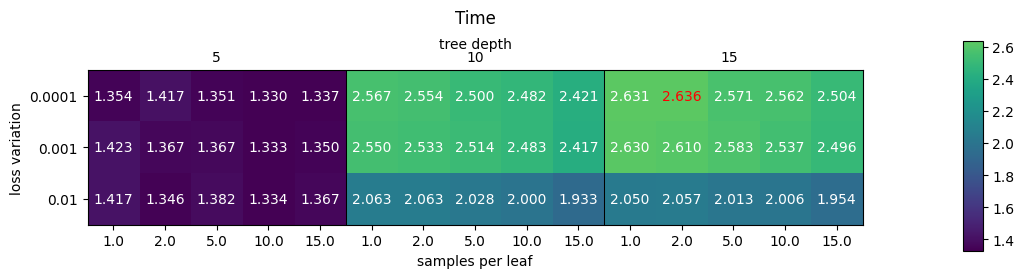

In [88]:
scoreInterest= 'time'
vmin=Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(10,3))

square=pd.DataFrame()
for sd in GRID['stop_depth']:
    df = Results[Results['stop_depth']==sd]
    df=df.pivot(index='stop_loss', columns='stop_leaf', values=scoreInterest)
    square=pd.concat([square,df], axis=1)

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("loss variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.3f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=4.5,c="black",linewidth=0.75,zorder=0)
ax.axvline(x=9.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(7, -1.5, 'Time', ha="center", va="center", fontsize=12)
ax.text(7, -1, 'tree depth', ha="center", va="center")
ax.text(2, -0.75, GRID['stop_depth'][0], ha="center", va="center")
ax.text(7, -0.75, GRID['stop_depth'][1], ha="center", va="center")
ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('Tree_'+scoreInterest,dpi=300)
plt.show()

La heatmap dei tempi di addestramento mostra come, nonostante le combinazioni con profondità massima 5 portino a performance peggiori, esse impieghino anche un tempo nettamente inferiore. Risultato intuitivo dal momento che l'albero ha un numero molto minore di ramificazioni e dunque l'algoritmo presenta un numero molto inferiore di iterazioni. 

## Bootstrap e Random forest

Un albero decisionale ha grandi potenzialità, ma è anche alto il rischio di creare overfitting.
Per evitare questa problematica spesso si applica una tecnica denotata _bootstrap_.

Dal training set $\mathcal{T}$ si campionano $B$ diversi training set $\mathcal{T}_1^*,\mathcal{T}_2^*,...,\mathcal{T}_B^*$ di dimensione $T'$ e per ciascuno di essi si addestra un diverso albero decisionale. La funzione di predizione aggregata, utilizzata per la predizione del campione $\boldsymbol{x}$ al termine della costruzione del Random Forest, è data dalle moda dei valori delle funzioni di predizione dei singoli alberi decisionali:

$$g_{boot}(\boldsymbol{x})=\argmax_{j\in\{0,1,...,p-1\}}\frac{1}{B}\sum_{b=1}^B\mathbb{1}_{\{g_{\mathcal{T}_b^*}(\boldsymbol{x})=j\}}$$

Per il campionamento di ciascun insieme di training bootstrappato per $T'$ diverse volte si seleziona casualmente un campione dall'insieme $\mathcal{T}$. I $T'$ campioni, che possono ammettere ripetizioni, compongono uno dei training set creati tramite bootstrap. Ognuno dei $B$ insiemi bootstrappati è creato in questo modo.

Il Random Forest è quindi lo strumento di classificazione che prevede l'utilizzo del bootstrap per la creazione di più alberi decisionali e che si riassume nella funzione di predizione espressa sopra.

## Applicazione del Random Forest

Per l'implementazione del Random Forest ci si serve della classe _RandomForest_ che contiene come attributi i valori che definiscono i criteri di arresto per ciascun albero, la quantità di campioni in ciascun training set bootstrappato in forma di percentuale della dimensione del training set complessivo e il numero di alberi.
I metodi della classe sono invece i seguenti:
- __`__init__`__, che viene eseguito al momento della costruzione di un nuovo oggetto _RandomForest_, fa partire l'esecuszione del metodo _bootstrap_ per la creazione dei training set bootstrappati e crea per ciascuno di essi l'albero decisionale corrispondente;
- __`bootstrap`__, che a partire dal training set originale restituisce un array tri-dimensionale contenente tutti i campioni dei singoli insiemi bootstrappati;
- __`predict`__, che a partire da un insieme di campioni e da un oggetto _RandomForest_ restituisce i valori delle predizioni.

In [20]:

class RandomForest:
    def __init__(self,training,stop_leaf,stop_depth,stop_loss,B,sub_samples):
        self.sub_samples=sub_samples
        self.stop_leaf = stop_leaf
        self.stop_depth = stop_depth
        self.stop_loss = stop_loss
        self.B = B
        boot_tau = self.bootstrap(training)
        self.trees = []
        for i in range(B):
            decision_tree = Tree(boot_tau[:,i,:],stop_leaf,stop_depth,stop_loss)
            self.trees.append(decision_tree)                     

    def bootstrap(self,training):
        n_sample = int(training.shape[0]*self.sub_samples)
        n_feature_class = training.shape[1]
        boot_tau = np.empty((n_sample,self.B,n_feature_class))
        for i in range(self.B):
            #tau = np.empty((n_sample,n_feature_class))
            index = np.random.randint(0, training.shape[0], size=n_sample)
            boot_tau[:,i,:] = training.iloc[index,:]
            #for j in range(n_sample):
            #    index = np.random.randint(0, training.shape[0])
            #    tau[j,:] = training.iloc[index,:]
            #boot_tau[:,i,:] = tau
        return boot_tau
    
    def predict(self,test):
        predictions = np.empty((test.shape[0],self.B))
        for i in range(self.B):
            pred = self.trees[i].predict(test)
            predictions[:,i] = pred
        prediction_function = np.empty((test.shape[0]))
        for j in range(test.shape[0]):
            p,c = np.unique(predictions[j,:],return_counts=True)
            prediction_function[j] = p[c.argmax()]
        #test["pred"] = prediction_function
        return prediction_function

In [21]:
training = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_val, y_val], axis=1)

### Grid Search

Anche in questo caso effettuiamo una Grid Search, scegliendo come iper-parametri i valori dei criteri di terminazione per ciascun albero e la frazione di campioni selezionati durante il bootstrap. Il numero di alberi della foresta è fissato a 100, valore considerato di default nelle funzioni già implementate in Python. La dimensione della foresta non è stata considerata un iper-parametro per ragioni computazionali.

In [ ]:
GRID = {
    'stop_leaf': [2,5,10,15],  #10,10,0.001
    'stop_depth': [10,15],
    'stop_loss': [0.01, 0.001, 0.0001],
    'B':[100],
    'sub_samples':[0.8,0.9,1]
}

cols={'train_accuracy':[],'validation_accuracy':[],'time':[]}
for k in GRID.keys():
    cols[k]=[]
Results=pd.DataFrame(cols)

for g in ParameterGrid(GRID):
    print('*')
    start=time.time()
    RF = RandomForest(training,**g)
    stop=time.time()

    pred_train = RF.predict(training)
    accuracy_train = accuracy_score(y_train,pred_train)
    pred_val = RF.predict(test)
    accuracy_val = accuracy_score(y_val,pred_val)

    rowToAppend=g.copy()
    rowToAppend['train_accuracy']=accuracy_train
    rowToAppend['validation_accuracy']=accuracy_val
    rowToAppend['time']=stop-start
    Results=pd.concat([Results,pd.Series(rowToAppend).to_frame().T],axis=0,ignore_index=True)

#display(Results)

In [27]:
display(Results)

,train_accuracy,validation_accuracy,time,stop_leaf,stop_depth,stop_loss,B,sub_samples
0,0.984557,0.978667,259.921937,2.0,10.0,0.0100,100.0,0.8
1,0.985319,0.977333,273.180225,2.0,10.0,0.0100,100.0,0.9
2,0.984747,0.977333,285.632340,2.0,10.0,0.0100,100.0,1.0
3,0.987989,0.977333,302.682623,2.0,10.0,0.0010,100.0,0.8
4,0.988179,0.980000,360.378358,2.0,10.0,0.0010,100.0,0.9
...,...,...,...,...,...,...,...,...
67,0.987035,0.981333,198.097642,15.0,15.0,0.0010,100.0,0.9
68,0.987417,0.977333,212.064256,15.0,15.0,0.0010,100.0,1.0
69,0.987607,0.977333,186.161303,15.0,15.0,0.0001,100.0,0.8
70,0.986845,0.978667,198.080764,15.0,15.0,0.0001,100.0,0.9


In [24]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\993930782.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\993930782.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\993930782.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\993930782.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\993930782.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df 

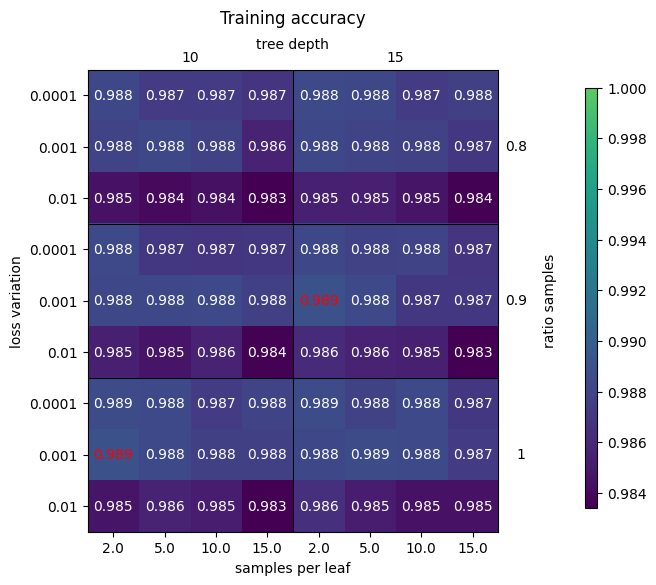

MIGLIORI IPERPARAMETRI


,train_accuracy,validation_accuracy,time,stop_leaf,stop_depth,stop_loss,B,sub_samples
5,0.988942,0.977333,322.704285,2.0,10.0,0.001,100.0,1.0


In [46]:
scoreInterest= 'train_accuracy'
vmin=Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(6,6))

square=pd.DataFrame()
for ss in GRID['sub_samples']:
    col=pd.DataFrame()
    for sd in GRID['stop_depth']:
        df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
        df=df.pivot(index='stop_loss', columns='stop_leaf', values=scoreInterest)
        col=pd.concat([col,df], axis=1)
    square=pd.concat([square,col])

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("loss variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.3f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=2.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=5.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(3.5, -1.5, 'Training accuracy', ha="center", va="center", fontsize=12)
ax.text(3.5, -1, 'tree depth', ha="center", va="center")
ax.text(1.5, -0.75, GRID['stop_depth'][0], ha="center", va="center")
ax.text(5.5, -0.75, GRID['stop_depth'][1], ha="center", va="center")
#ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")
ax.text(8.5, 4, 'ratio samples', ha="center", va="center", rotation='vertical')
ax.text(7.85, 1, GRID['sub_samples'][0], ha="center", va="center")
ax.text(7.85, 4, GRID['sub_samples'][1], ha="center", va="center")
ax.text(7.85, 7, GRID['sub_samples'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('RF_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=Results[scoreInterest].astype(float).idxmax()
bestModel = Results.iloc[max_elem_row]
display(pd.DataFrame(bestModel).transpose())

Nel caso del Random Forest, l'introduzione di casulaità e il fatto che il procedimento eseguito durante l'addestramento e durante la predizione sono diversi fanno lì che l'accuratezza migliore sul Training set non sia necessariamente quella corrispondente alla combinazione più blanda dei valori di terminazione. Si può però notare come il citerio di terminazione basato sul migioramento della loss risulti troppo stringente quando si pone il valore a 0.01.

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3334730888.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3334730888.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3334730888.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3334730888.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3334730888.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


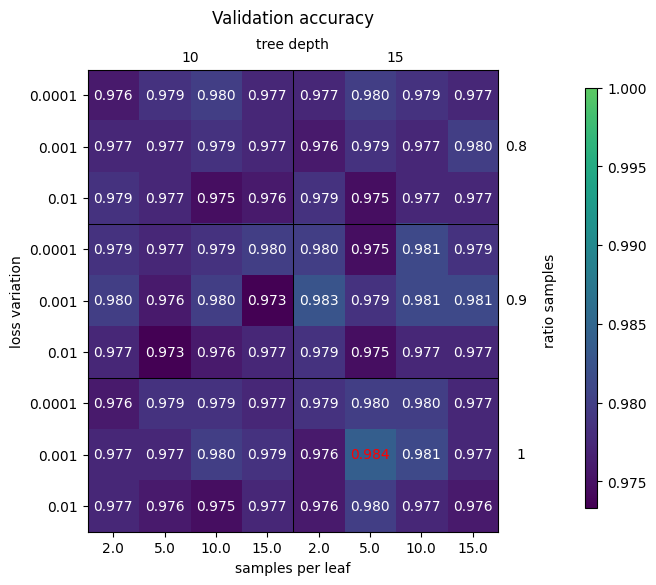

MIGLIORI IPERPARAMETRI


,train_accuracy,validation_accuracy,time,stop_leaf,stop_depth,stop_loss,B,sub_samples
50,0.988561,0.984,213.246614,5.0,15.0,0.001,100.0,1.0


In [45]:
scoreInterest= 'validation_accuracy'
vmin=Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(6,6))

square=pd.DataFrame()
for ss in GRID['sub_samples']:
    col=pd.DataFrame()
    for sd in GRID['stop_depth']:
        df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
        df=df.pivot(index='stop_loss', columns='stop_leaf', values=scoreInterest)
        col=pd.concat([col,df], axis=1)
    square=pd.concat([square,col])

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("loss variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.3f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=2.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=5.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(3.5, -1.5, 'Validation accuracy', ha="center", va="center", fontsize=12)
ax.text(3.5, -1, 'tree depth', ha="center", va="center")
ax.text(1.5, -0.75, GRID['stop_depth'][0], ha="center", va="center")
ax.text(5.5, -0.75, GRID['stop_depth'][1], ha="center", va="center")
#ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")
ax.text(8.5, 4, 'ratio samples', ha="center", va="center", rotation='vertical')
ax.text(7.85, 1, GRID['sub_samples'][0], ha="center", va="center")
ax.text(7.85, 4, GRID['sub_samples'][1], ha="center", va="center")
ax.text(7.85, 7, GRID['sub_samples'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('RF_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=Results[scoreInterest].astype(float).idxmax()
bestModel = Results.iloc[max_elem_row]
display(pd.DataFrame(bestModel).transpose())

Nella heatmap sopra, si può osservare come sia più difficile trovare valori uguali vicini, rispetto al caso con un singolo albero decisionale. Questa caratteristica si puù spiegare grazie alla casulaità introdotta con il bootstrap.

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\968971894.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\968971894.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\968971894.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\968971894.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\968971894.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df 

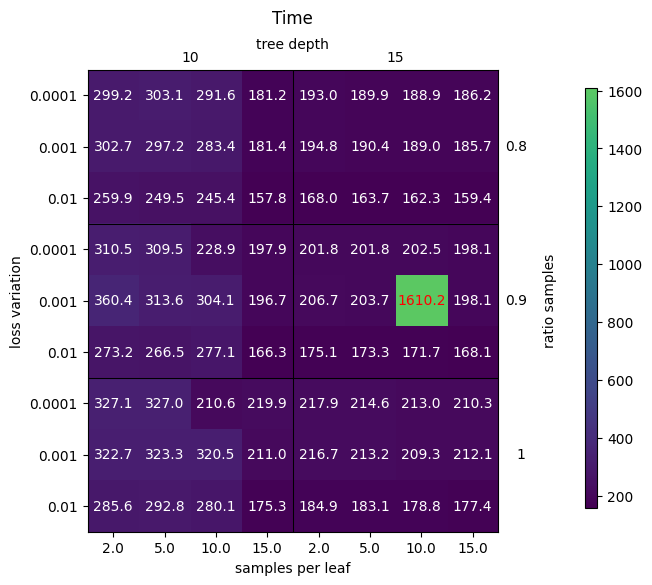

In [48]:
scoreInterest= 'time'
vmin=Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(6,6))

square=pd.DataFrame()
for ss in GRID['sub_samples']:
    col=pd.DataFrame()
    for sd in GRID['stop_depth']:
        df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
        df=df.pivot(index='stop_loss', columns='stop_leaf', values=scoreInterest)
        col=pd.concat([col,df], axis=1)
    square=pd.concat([square,col])

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("loss variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.1f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=2.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=5.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(3.5, -1.5, 'Time', ha="center", va="center", fontsize=12)
ax.text(3.5, -1, 'tree depth', ha="center", va="center")
ax.text(1.5, -0.75, GRID['stop_depth'][0], ha="center", va="center")
ax.text(5.5, -0.75, GRID['stop_depth'][1], ha="center", va="center")
#ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")
ax.text(8.5, 4, 'ratio samples', ha="center", va="center", rotation='vertical')
ax.text(7.85, 1, GRID['sub_samples'][0], ha="center", va="center")
ax.text(7.85, 4, GRID['sub_samples'][1], ha="center", va="center")
ax.text(7.85, 7, GRID['sub_samples'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('RF_'+scoreInterest,dpi=300)
plt.show()

L'esito dei tempi misurati è piuttosto inaspettato. C'è una grossa differenza di valori soprattutto in corrispondenza di una singola combinazione. Studiando intuitivamente il contesto in cui il codice è stato eseguito, ho ricostruito che il computer utilizzato per l'esecuzione è andato in standby per un lasso di tempo. Documentandomi ho scoperto che, quando il computer va in standby durante l'esecuzione del codice, il tempo continua a scorrere, mentre l'esecuzione vera e propria si interrompe, fino a quando lo schermo non viene nuovamente attivato. Il momento di interruzione può esere coinciso con l'addestramento di quel Random Forest specifico.

Per ovviare al problema ho provveduto nuovamente con l'addestramento di quello specifico Random Forest e riaggiornato la heatmap, come mostrato in seguito.

In [50]:
training = pd.concat([X_train, y_train], axis=1)

start=time.time()
fix_RF = RandomForest(training,10,15,0.001,100,0.9)
stop=time.time()

fix_time = stop-start
print(fix_time)

205.89866161346436


In [52]:
test = pd.concat([X_val, y_val], axis=1)
pred = fix_RF.predict(test)

accuracy = accuracy_score(test["class"],pred)
print(accuracy)

0.98


Come si può vedere il valore dell'accuracy sul Validation set della singola combinazione risulta analogo a quanto ottenuto con la prima esecuzioone.

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\875250979.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\875250979.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\875250979.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\875250979.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\875250979.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df 

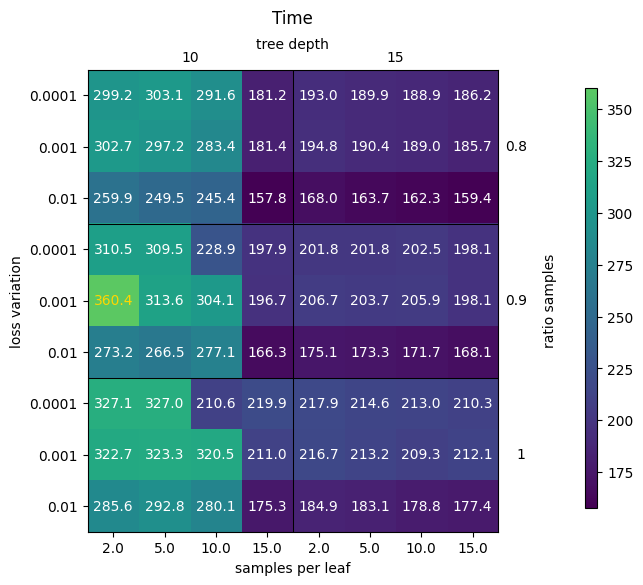

In [55]:
scoreInterest= 'time'
vmin=Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=Results[scoreInterest].nlargest(2).iloc[-1]

fig,ax=plt.subplots(1,1,figsize=(6,6))

square=pd.DataFrame()
for ss in GRID['sub_samples']:
    col=pd.DataFrame()
    for sd in GRID['stop_depth']:
        df = Results[Results['stop_depth']==sd][Results['sub_samples']==ss]
        df=df.pivot(index='stop_loss', columns='stop_leaf', values=scoreInterest)
        col=pd.concat([col,df], axis=1)
    square=pd.concat([square,col])

square.iloc[4,6]=fix_time

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("loss variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.1f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=2.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=5.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(3.5, -1.5, 'Time', ha="center", va="center", fontsize=12)
ax.text(3.5, -1, 'tree depth', ha="center", va="center")
ax.text(1.5, -0.75, GRID['stop_depth'][0], ha="center", va="center")
ax.text(5.5, -0.75, GRID['stop_depth'][1], ha="center", va="center")
#ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")
ax.text(8.5, 4, 'ratio samples', ha="center", va="center", rotation='vertical')
ax.text(7.85, 1, GRID['sub_samples'][0], ha="center", va="center")
ax.text(7.85, 4, GRID['sub_samples'][1], ha="center", va="center")
ax.text(7.85, 7, GRID['sub_samples'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('RF_fix_'+scoreInterest,dpi=300)
plt.show()

Con questa nuova heatmap si è aggiustato il problema di disallineamento della singola combinazione, tuttavia si può ancora notare un disallineamento delle prime 3 colonne rispetto alle successive. Lo stacco tra le due scale di valori è evidente. La differenza dei tempi non è giustificabile per mezzo della teoria, secondo cui un limite più blando sulla profondità massima dell'albero dovrebbe portare a tempi più lunghi di addestramento, contrariamente a quanto si osserva. Anche in questo caso la netta differenza è dovuta probabilmente alle modalità con cui è stato eseguito il codice: durante la prima metà dell'esecuzione il computer è stato simultaneamento utilizzato per ricerche su Chrome e scrittura di altre successive parti del codice, richiedendo maggiori operazioni; successivamente tutti gli altri utilizzi sono stati interrotti e il computer è stato attaccato alla corrente, consentendo una maggiore potenza di calcolo per l'esecuzione. Infatti, a favore di questa deduzione, vediamo che le 27 combinazioni che hanno richiesto una maggiore quantità di tempo sono esattamente le prime 27 coombinazioni considerate in assoluto dalla Grid Search, quindi ciò che ha determinato lo stacco è stato l'ordine di esecuzione delle combinazioni, più che i valori degli iper-parametri corrispondenti.

## Performance dell'albero decisionale e del Random Forest

Dopo aver selezionato il modello migliore nel caso di singolo albero decisionale e nel caso di Random Forest, confrontiamo l'accuratezza dei due modelli sulla previsione delle classi dei campioni del Test set.

In [56]:
training = pd.concat([X_train, y_train], axis=1)
validation = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [57]:
# Albero decisionale
start=time.time()
best_decision_tree = Tree(training.values,10,10,0.001)
stop=time.time()

best_pred_train = best_decision_tree.predict(training)
best_accuracy_train = accuracy_score(y_train,best_pred_train)
best_pred_val = best_decision_tree.predict(validation)
best_accuracy_val = accuracy_score(y_val,best_pred_val)
best_pred_test = best_decision_tree.predict(test)
best_accuracy_test = accuracy_score(y_test,best_pred_test)

best_time=stop-start

In [59]:
# Random Forest
start=time.time()
best_RF = RandomForest(training,5,15,0.001,100,1)
stop=time.time()

RF_best_pred_train = best_RF.predict(training)
RF_best_accuracy_train = accuracy_score(y_train,RF_best_pred_train)
RF_best_pred_val = best_RF.predict(validation)
RF_best_accuracy_val = accuracy_score(y_val,RF_best_pred_val)
RF_best_pred_test = best_RF.predict(test)
RF_best_accuracy_test = accuracy_score(y_test,RF_best_pred_test)

RF_best_time=stop-start

In [60]:
performances_dict = {'Accuracy training': [best_accuracy_train, RF_best_accuracy_train], 'Accuracy validation': [best_accuracy_val, RF_best_accuracy_val], 'Accuracy test': [best_accuracy_test, RF_best_accuracy_test], 'Training time': [best_time, RF_best_time]}
performances = pd.DataFrame(data=performances_dict, index=["Albero decisionale", "Random Forest"])
display(performances)

,Accuracy training,Accuracy validation,Accuracy test,Training time
Albero decisionale,0.981316,0.946667,0.928619,2.620014
Random Forest,0.988751,0.981333,0.961975,223.598666


Come si può facilmente osservare dalla tabella, il Random Forest presenta performance migliori sia sul training set, sia sul Validation set, sia sul test set. Tuttavia, il tempo impiegato per l'addestramento è circa 100 volte tanto, passando dai 2 secondi dell'albero decisionale ai quasi 4 minuti del Random Forest. Fattore moltiplicativo di circa 100 non è un caso, dal momento che il RF addestra 100 alberi, contro il singolo albero decisionale del primo esperimento.

### Performance sui dati di scrittori ignoti

Valutiamo ora le performance dei due modelli sulla predizione di cifre scritte da scrittori ignoti.

In [11]:
test_i = suggestedTestData.copy()

In [62]:
# Albero decisionale
best_pred_test_i = best_decision_tree.predict(test_i)
best_accuracy_test_i = accuracy_score(test_i['class'],best_pred_test_i)

# Random Forest
RF_best_pred_test_i = best_RF.predict(test_i)
RF_best_accuracy_test_i = accuracy_score(test_i['class'],RF_best_pred_test_i)

In [63]:
print('SCRITTORI IGNOTI')
performances_dict_i = {'Accuracy': [best_accuracy_test_i, RF_best_accuracy_test_i]}
performances_i = pd.DataFrame(data=performances_dict_i, index=["Albero decisionale", "Random Forest"])
display(performances_i)

SCRITTORI IGNOTI


,Accuracy
Albero decisionale,0.887650
Random Forest,0.930818


Anche in questo caso il RF risulta migliore in termini di accuratezza. I risultati sono però complessivamente evidentemente peggiori rispetto a quanto visto con il test set creato da noi. Ciò potrebbe essere dovuto dal fatto che gli alberi decisionali tendono molto ad "abiuarsi" e a "conoscere i dati", quindi quando gli si propone qualcosa di simile a quanto hanno visto nella fase di training, funzionano molto bene. Tuttavia, quando provano a predirre la classe di campioni sufficientemente diversi da tutti quelli già visti, riscontrano maggiori difficoltà. La differenza è minima, ma facilmente riconoscibile. Per comprendere meglio facciamo un esempio.

Abbiamo visto nell'introduzione di questa tesina che i numeri 1 vengono tracciati dall'alto verso il basso nella gran maggioranza dei casi. Supponiamo che gli autori che tracciano i numeri 1 dal basso verso l'alto facciano tutti parte del gruppo degli scrittori ignoti. I punti attraversati in questo caso si troveranno in posizioni simili rispetto a quelle degli altri scrittori, ma in ordine inverso. Quindi, quando si considera un solo predittore per determinare uno splitting, per esempio la coordinata $y$ del primo punto attraversato, tutti i numeri 1 verranno mandati nel ramo dell'albero in cui tale coordinata $y$ è più alta, poichè gli scrittori che compongono il Training set hanno questo primo punto nell aparte alta del riquadro. Quando bisogna applicare la stessa splitting rule sui campioni da scrittori ignoti, tuttavia, i numeri 1 verranno mandati nel ramo opporto dell'albero, poichè la coordinata $y$ del primo punto sarà nella parte bassa del riquadro. I campioni dei numeri 1 del Test set su scrittori ignoti andranno a capitare in nodi foglia dove la funzione di predizione corrisponderà molto probabilmente ad un altro valore, contribuendo così a ad una accuratezza più bassa.

## Applicazione del Random Forest per mezzo delle librerie Scikit-learn

Proviamo ora a costruire dei modelli per mezzo delle librerie di _Scikit-learn_, cercando di mantenere gli stessi criteri di terminazione e gli stessi iper-parametri utilizzati fino a questo momento per le Grid Search.

In [23]:
training = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_val, y_val], axis=1)

In [ ]:
GRID = {
    'min_samples_split': [2,5,10,15],  #10,10,0.001
    'max_depth': [10,15],
    'min_impurity_decrease': [0.01, 0.001, 0.0001],
    'max_samples':[0.8,0.9,1]
}

cols={'train_accuracy':[],'validation_accuracy':[],'time':[]}
for k in GRID.keys():
    cols[k]=[]
SL_Results=pd.DataFrame(cols)

for g in ParameterGrid(GRID):
    print('*')
    start=time.time()
    #Dichiarazione del random forest
    randomForest = RandomForestClassifier(n_estimators=100, criterion='log_loss', max_features=None, bootstrap=True, **g)
    randomForest.fit(X_train, y_train)
    stop=time.time()

    pred_train = randomForest.predict(X_train)
    accuracy_train = accuracy_score(y_train,pred_train)
    pred_val = randomForest.predict(X_val)
    accuracy_val = accuracy_score(y_val,pred_val)

    rowToAppend=g.copy()
    rowToAppend['train_accuracy']=accuracy_train
    rowToAppend['validation_accuracy']=accuracy_val
    rowToAppend['time']=stop-start
    SL_Results=pd.concat([SL_Results,pd.Series(rowToAppend).to_frame().T],axis=0,ignore_index=True)

#display(SL_Results)

In [70]:
display(SL_Results)

,train_accuracy,validation_accuracy,time,min_samples_split,max_depth,min_impurity_decrease,max_samples
0,0.949094,0.938667,1.468474,2.0,10.0,0.0100,0.8
1,0.951192,0.945333,1.471887,5.0,10.0,0.0100,0.8
2,0.952145,0.946667,1.513453,10.0,10.0,0.0100,0.8
3,0.950048,0.940000,1.466368,15.0,10.0,0.0100,0.8
4,0.998284,0.986667,1.733799,2.0,10.0,0.0010,0.8
...,...,...,...,...,...,...,...
67,0.098189,0.069333,0.063096,15.0,15.0,0.0010,1.0
68,0.104099,0.122667,0.065558,2.0,15.0,0.0001,1.0
69,0.092088,0.101333,0.062440,5.0,15.0,0.0001,1.0
70,0.101621,0.068000,0.046912,10.0,15.0,0.0001,1.0


In [71]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\1484929000.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\1484929000.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\1484929000.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\1484929000.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\1484929000.py:13: UserWarning: Boolean Series key will be rein

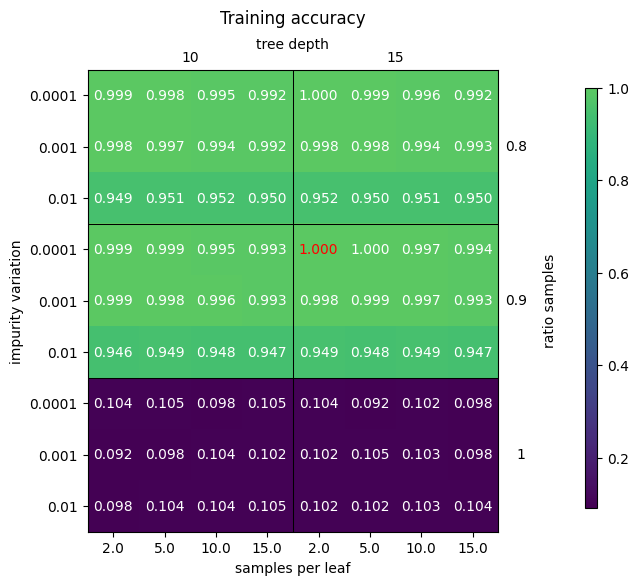

MIGLIORI IPERPARAMETRI


,train_accuracy,validation_accuracy,time,min_samples_split,max_depth,min_impurity_decrease,max_samples
56,1.0,0.989333,1.72938,2.0,15.0,0.0001,0.9


In [72]:
scoreInterest= 'train_accuracy'
vmin=SL_Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=SL_Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(6,6))

square=pd.DataFrame()
for ss in GRID['max_samples']:
    col=pd.DataFrame()
    for sd in GRID['max_depth']:
        df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
        df=df.pivot(index='min_impurity_decrease', columns='min_samples_split', values=scoreInterest)
        col=pd.concat([col,df], axis=1)
    square=pd.concat([square,col])

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("impurity variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==SL_Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.3f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=2.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=5.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(3.5, -1.5, 'Training accuracy', ha="center", va="center", fontsize=12)
ax.text(3.5, -1, 'tree depth', ha="center", va="center")
ax.text(1.5, -0.75, GRID['max_depth'][0], ha="center", va="center")
ax.text(5.5, -0.75, GRID['max_depth'][1], ha="center", va="center")
#ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")
ax.text(8.5, 4, 'ratio samples', ha="center", va="center", rotation='vertical')
ax.text(7.85, 1, GRID['max_samples'][0], ha="center", va="center")
ax.text(7.85, 4, GRID['max_samples'][1], ha="center", va="center")
ax.text(7.85, 7, GRID['max_samples'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('RF_SL_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=SL_Results[scoreInterest].astype(float).idxmax()
bestModel = SL_Results.iloc[max_elem_row]
display(pd.DataFrame(bestModel).transpose())

A differenza di quanto visto prima, la scelta del rapporto 1 risulta molto sconveniente. La combinazione migliore prevede il rapporto 0.9 e arriva ad avere una accuratezza del 100% sul Training set.

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3710206045.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3710206045.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3710206045.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3710206045.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3710206045.py:13: UserWarning: Boolean Series key will be rein

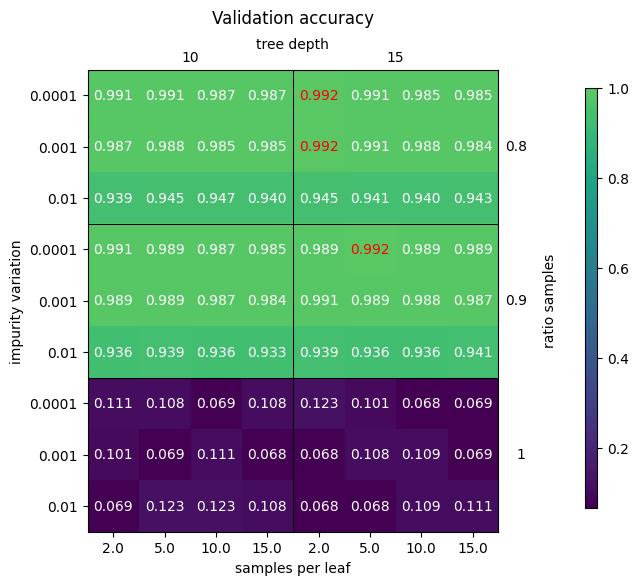

MIGLIORI IPERPARAMETRI


,train_accuracy,validation_accuracy,time,min_samples_split,max_depth,min_impurity_decrease,max_samples
40,0.998093,0.992,1.615799,2.0,15.0,0.001,0.8


In [73]:
scoreInterest= 'validation_accuracy'
vmin=SL_Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=SL_Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(6,6))

square=pd.DataFrame()
for ss in GRID['max_samples']:
    col=pd.DataFrame()
    for sd in GRID['max_depth']:
        df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
        df=df.pivot(index='min_impurity_decrease', columns='min_samples_split', values=scoreInterest)
        col=pd.concat([col,df], axis=1)
    square=pd.concat([square,col])

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("impurity variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==SL_Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.3f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=2.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=5.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(3.5, -1.5, 'Validation accuracy', ha="center", va="center", fontsize=12)
ax.text(3.5, -1, 'tree depth', ha="center", va="center")
ax.text(1.5, -0.75, GRID['max_depth'][0], ha="center", va="center")
ax.text(5.5, -0.75, GRID['max_depth'][1], ha="center", va="center")
#ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")
ax.text(8.5, 4, 'ratio samples', ha="center", va="center", rotation='vertical')
ax.text(7.85, 1, GRID['max_samples'][0], ha="center", va="center")
ax.text(7.85, 4, GRID['max_samples'][1], ha="center", va="center")
ax.text(7.85, 7, GRID['max_samples'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('RF_SL_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=SL_Results[scoreInterest].astype(float).idxmax()
bestModel = SL_Results.iloc[max_elem_row]
display(pd.DataFrame(bestModel).transpose())

C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3568485634.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3568485634.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3568485634.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3568485634.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
C:\Users\ghiot\AppData\Local\Temp\ipykernel_16820\3568485634.py:13: UserWarning: Boolean Series key will be rein

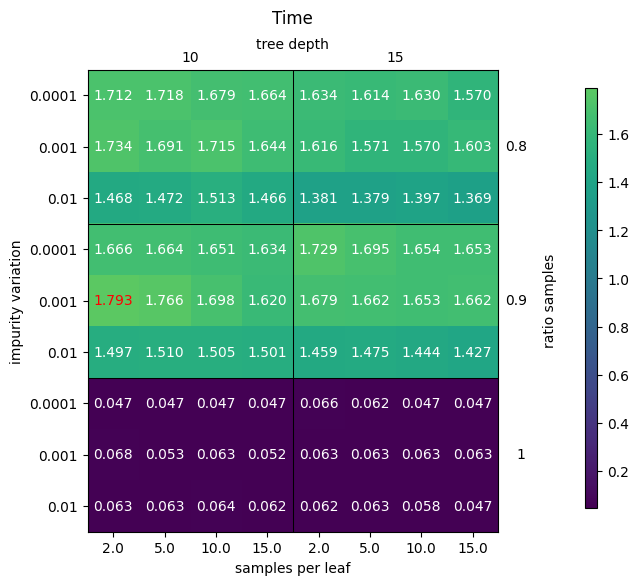

MIGLIORI IPERPARAMETRI


,train_accuracy,validation_accuracy,time,min_samples_split,max_depth,min_impurity_decrease,max_samples
16,0.998665,0.989333,1.793216,2.0,10.0,0.001,0.9


In [74]:
scoreInterest= 'time'
vmin=SL_Results[scoreInterest].min()
vmax=1
if scoreInterest=='time':
    vmax=SL_Results[scoreInterest].max()

fig,ax=plt.subplots(1,1,figsize=(6,6))

square=pd.DataFrame()
for ss in GRID['max_samples']:
    col=pd.DataFrame()
    for sd in GRID['max_depth']:
        df = SL_Results[SL_Results['max_depth']==sd][SL_Results['max_samples']==ss]
        df=df.pivot(index='min_impurity_decrease', columns='min_samples_split', values=scoreInterest)
        col=pd.concat([col,df], axis=1)
    square=pd.concat([square,col])

#ax=axs[1,1]
im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
ax.set_yticks(range(len(square.index)))
ax.set_yticklabels(square.index)
ax.set_xticks(range(len(square.columns)))
ax.set_xticklabels(square.columns)
#ax.title.set_text(bs)
ax.set_xlabel("samples per leaf")
ax.set_ylabel("impurity variation")
for a in range(len(square.index)):
    for j in range(len(square.columns)):
        c="w"
        if square.iloc[a, j]==SL_Results[scoreInterest].max():
            c="red"
        elif square.iloc[a, j]==square.values.max():
            c="gold"
        text = ax.text(j, a, "{0:.3f}".format(square.iloc[a, j]),
                    ha="center", va="center", color=c)
#Linee verticali e orizzontali di separazione
ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=2.5,c="black",linewidth=0.75,zorder=0)
ax.axhline(y=5.5,c="black",linewidth=0.75,zorder=0)
#Testi aggiuntivi degli assi mancanti e titolo
ax.text(3.5, -1.5, 'Time', ha="center", va="center", fontsize=12)
ax.text(3.5, -1, 'tree depth', ha="center", va="center")
ax.text(1.5, -0.75, GRID['max_depth'][0], ha="center", va="center")
ax.text(5.5, -0.75, GRID['max_depth'][1], ha="center", va="center")
#ax.text(11.75, -0.75, GRID['stop_depth'][2], ha="left", va="center")
ax.text(8.5, 4, 'ratio samples', ha="center", va="center", rotation='vertical')
ax.text(7.85, 1, GRID['max_samples'][0], ha="center", va="center")
ax.text(7.85, 4, GRID['max_samples'][1], ha="center", va="center")
ax.text(7.85, 7, GRID['max_samples'][2], ha="left", va="center")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('RF_SL_'+scoreInterest,dpi=300)
plt.show()

Oltre ad avere performance molto basse, i modelli con rapporto 1 impiegano un tempo molto inferiore per l'addestramento.

Le differenze significative che si possono notare tra il modello implementato da noi e quello proposto possono essere causate dalla diversa funzione di loss utilizzata. La funzione di loss utilizzata da Schikit-learn è infatti di tipo logaritmico. Potrebbero esserci anche altre differenze, come per esempio nell'ottimizzazione.  
Come emerge dalle heatmap dei tempi, le funzioni pre-scritte sono estremamente più rapide, perchè molto meglio ottimizzate.

### Test del Random Forest delle librerie Scikit-learn

Testiamo ora il modello migliore su dati del Test set e sui dati di scrittori ignoti.

In [13]:
# Addestramento
start=time.time()
randomForest_SL = RandomForestClassifier(n_estimators=100, criterion='log_loss', max_features=None, bootstrap=True, min_samples_split=2, max_depth=15, min_impurity_decrease=0.001, max_samples=0.8)
randomForest_SL.fit(X_train, y_train)
stop=time.time()
RF_SL_best_time=stop-start

# Scrittori noti
RF_SL_best_pred_test = randomForest_SL.predict(X_test)
RF_SL_best_accuracy_test = accuracy_score(y_test,RF_SL_best_pred_test)

# Scrittori ignoti
RF_SL_best_pred_test_i = randomForest_SL.predict(test_i.iloc[:,:-1])
RF_SL_best_accuracy_test_i = accuracy_score(test_i['class'],RF_SL_best_pred_test_i)


In [14]:
print(RF_SL_best_time)

2.641364336013794


# Confronto dei risultati

In [27]:
d = {'Tempo Selezione+Addestramento': ['1m 56s', '~5h', '2m 12s', '~57m 36s', '~1h 33m 30s'], 'Tempo addestramento': ['3s', '3m 43s', '3s', '6s', '-']}
d_n = {'Accuracy': [0.928619, 0.961975, RF_SL_best_accuracy_test, 0.989993, 0.996664]}
d_ig = {'Accuracy': [0.887650, 0.930818, RF_SL_best_accuracy_test_i, 0.961407, 0.984563]}
comparison_intro = pd.DataFrame(data=d)
comparison_n = pd.DataFrame(data=d_n)
comparison_ig = pd.DataFrame(data=d_ig)

comparison = pd.concat([comparison_intro, comparison_n, comparison_ig], axis=1, keys=['Addestramento', 'Test su scrittori noti', 'Test su scrittori ignoti'])
display(comparison.rename(index={0: "Albero decisionale (a mano)", 1: "Random Forest (a mano)", 2: "Random Forest", 3: "MLP", 4: "SVM"}))

Addestramento                      \
                            Tempo Selezione+Addestramento Tempo addestramento   
Albero decisionale (a mano)                        1m 56s                  3s   
Random Forest (a mano)                                ~5h              3m 43s   
Random Forest                                      2m 12s                  3s   
MLP                                              ~57m 36s                  6s   
SVM                                           ~1h 33m 30s                   -   

                            Test su scrittori noti Test su scrittori ignoti  
                                          Accuracy                 Accuracy  
Albero decisionale (a mano)               0.928619                 0.887650  
Random Forest (a mano)                    0.961975                 0.930818  
Random Forest                             0.981321                 0.951401  
MLP                                       0.989993                 0.961407  
SVM                                       0.996664                 0.984563

Ecco qui raccolti i tempi e le performance dei vari modelli sperimentati durante questi corsi, in ordine dal meno perdormante al più performante.
I due modelli implementati a mano sono naturalmente i meno performanti, ma i risultati sono comunque buoni. SVM si conferma il modello migliore per questo dataset, anche il tempo per la selezione degli iper-parametri è molto maggiore di quello impiegato dal Random Forest. Il numero di combinazioni per l'SVM era maggiore, ma non da giustificare la grossa differenza di tempistiche.  
Una volta selezionato il modello migliore, il tempo di addestramento per Albero decisionale, Random Forest e MLP è più o meno sullo stesso ordine di grandezza. Il tempo impigato dal Random Forest implementato a mano è invece molto maggiore.  
Come abbiamo visto in precedenza, non è da tralasciare il metodo e il computer con qui vengono effettuate le sperimentazioni. Il computer utilizzato in questi mesi è nuovo e più potente, paragonato al vecchio utilizzato durante il corso di Matematica per l'Intelligenza Artificiale.

Tutti i modelli presentano un calo evidente nelle performance quando applicati ai dati di scrittori ignoti.

# Fonti

- Alpaydin, E. & Alimoglu, F. (1996). Pen-Based Recognition of Handwritten Digits [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5MG6K.
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html Documentazione di Scikit-learn sul Random Forest 